In [4]:
import sys
sys.path.append('../')

In [5]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import fits_to_pandas, pandas_to_fits, decode_str_columns
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
from astropy.coordinates import SkyCoord
import astropy.coordinates 
import astropy.units as u
import astroquery
import sklearn
from sklearn import model_selection

%matplotlib inline

load matches data

In [6]:
desi = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_xmatch.pkl')
desi = desi.replace(np.inf, np.nan, inplace=False)
desi = desi.replace(-np.inf, np.nan, inplace=False)
desi

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,nway_desi_id,nway_Separation_EROSITA_DESI,nway_prob_has_match,nway_prob_this_match,nway_nnmag_grzw1w2w3w4,nway_nnmag_grzw1w2,nway_nnmag_grz,nway_n_match_flag_0,nway_n_match_flag_2,nway_is_duplicated,nway_is_confused,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,GAIA_angDist,GAIA_DR3Name,GAIA_RAdeg,GAIA_DEdeg,GAIA_errHalfMaj,GAIA_errHalfMin,GAIA_errPosAng,GAIA_SolID,GAIA_Source,GAIA_RandomI,GAIA_e_RAdeg,GAIA_e_DEdeg,GAIA_Plx,GAIA_e_Plx,GAIA_RPlx,GAIA_PM,GAIA_pmRA,GAIA_e_pmRA,GAIA_pmDE,GAIA_e_pmDE,GAIA_RADEcor,GAIA_RAPlxcor,GAIA_RApmRAcor,GAIA_RApmDEcor,GAIA_DEPlxcor,GAIA_DEpmRAcor,GAIA_DEpmDEcor,GAIA_PlxpmRAcor,GAIA_PlxpmDEcor,GAIA_pmRApmDEcor,GAIA_NAL,GAIA_NAC,GAIA_NgAL,GAIA_NbAL,GAIA_gofAL,GAIA_chi2AL,GAIA_epsi,GAIA_sepsi,GAIA_Solved,GAIA_APF,GAIA_nueff,GAIA_pscol,GAIA_e_pscol,GAIA_RApscolCorr,GAIA_DEpscolCorr,GAIA_PlxpscolCorr,GAIA_pmRApscolCorr,GAIA_pmDEpscolCorr,GAIA_MatchObsA,GAIA_Nper,GAIA_amax,GAIA_MatchObs,GAIA_IPDgofha,GAIA_IPDgofhp,GAIA_IPDfmp,GAIA_IPDfow,GAIA_RUWE,GAIA_Dup,GAIA_o_Gmag,GAIA_FG,GAIA_e_FG,GAIA_RFG,GAIA_Gmag,GAIA_e_Gmag,GAIA_o_BPmag,GAIA_FBP,GAIA_e_FBP,GAIA_RFBP,GAIA_BPmag,GAIA_e_BPmag,GAIA_o_RPmag,GAIA_FRP,GAIA_e_FRP,GAIA_RFRP,GAIA_RPmag,GAIA_e_RPmag,GAIA_E(BP/RP),GAIA_NBPcont,GAIA_NBPblend,GAIA_NRPcont,GAIA_NRPblend,GAIA_Mode,GAIA_BP-RP,GAIA_BP-G,GAIA_G-RP,GAIA_RV,GAIA_e_RV,GAIA_n_RV,GAIA_o_RV,GAIA_o_RVd,GAIA_RVNper,GAIA_RVS/N,GAIA_RVgof,GAIA_RVchi2,GAIA_RVTdur,GAIA_RVamp,GAIA_RVtempTeff,GAIA_RVtemplogg,GAIA_RVtemp[Fe/H],GAIA_Vatmparam,GAIA_vbroad,GAIA_e_Vbroad,GAIA_o_Vbroad,GAIA_GRVSmag,GAIA_e_GRVSmag,GAIA_o_GRVSmag,GAIA_RVSS/N,GAIA_VarFlag,GAIA_PQSO,GAIA_PGal,GAIA_PSS,GAIA_Teff,GAIA_b_Teff,GAIA_B_Teff,GAIA_logg,GAIA_b_logg,GAIA_B_logg,GAIA_[Fe/H],GAIA_b_[Fe/H],GAIA_B_[Fe/H],GAIA_Dist,GAIA_b_Dist,GAIA_B_Dist,GAIA_A0,GAIA_b_A0,GAIA_B_A0,GAIA_AG,GAIA_b_AG,GAIA_B_AG,GAIA_E(BP-RP),GAIA_b_E(BP-RP),GAIA_B_E(BP-RP),GAIA_Lib,GAIA_RAJ2000,GAIA_DEJ2000,GAIA_e_RAJ2000,GAIA_e_DEJ2000,GAIA_RADEcorJ2000,SDSS_angDist,SDSS_objID,SDSS_RA_ICRS,SDSS_DE_ICRS,SDSS_errHalfMaj,SDSS_errHalfMin,SDSS_errPosAng,SDSS_mode,SDSS_class,SDSS_clean,SDSS_e_RA_ICRS,SDSS_e_DE_ICRS,SDSS_umag,SDSS_gmag,SDSS_rmag,SDSS_imag,SDSS_zmag,SDSS_e_umag,SDSS_e_gmag,SDSS_e_rmag,SDSS_e_imag,SDSS_e_zmag,SDSS_zsp,SDSS_e_zsp,SDSS_f_zsp,SDSS_spCl,SDSS_subCl,SDSS_pmRA,SDSS_pmDE,SDSS_e_pmRA,SDSS_e_pmDE,SDSS_sigRA,SDSS_sigDE,SDSS_zph,SDSS_e_zph,SDSS_<zph>,SDSS_Q,SDSS_SDSS16,SDSS_Sp-ID,SDSS_MJD,MILQ_angDist,MILQ_RA,MILQ_DEC,MILQ_NAME,MILQ_TYPE,MILQ_RMAG,MILQ_BMAG,MILQ_COMMENT,MILQ_R,MILQ_B,MILQ_Z,MILQ_CITE,MILQ_ZCITE,MILQ_RXPCT,MILQ_QPCT,MILQ_XNAME,MILQ_RNAME,MILQ_LOBE1,MILQ_LOBE2,class_GAIA_class,class_SDSS_class,class_MILQ_class,class_final,redshift_final
0,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006185,7.077317,154.763934,56.505585,853324209744036352,7.576342,1,0,20.950485,-1.0,0,SDSS J101902.92+563016.4,0.949746,QSO,7.576898,1,0,0,2,16.915001,16.554001,12.382,12.1,5.0,0.7,2,1,1,12376583038144

In [7]:
extragal_filter = desi.eval("class_final in ['QSO', 'GALAXY']")
desi.loc[extragal_filter, 'class_distance'] = 'secure_extragal'

gal_filter = desi.eval("class_final in ['STAR']") #STAR STAR_SINGLE is not taken into account, although we may try later
desi.loc[gal_filter, 'class_distance'] = 'secure_gal'

desi.loc[desi.class_distance.isna(), 'class_distance'] = 'unknown'

add colors

In [8]:
desi['desi_col_gr'] = desi['desi_dered_mag_g'] - desi['desi_dered_mag_r']
desi['desi_col_rz'] = desi['desi_dered_mag_r'] - desi['desi_dered_mag_z']
desi['desi_col_zw1'] = desi['desi_dered_mag_z'] - desi['desi_dered_mag_w1']
desi['desi_col_w1w2'] = desi['desi_dered_mag_w1'] - desi['desi_dered_mag_w2']

desi['desi_fx_over_r'] =  desi['ML_FLUX_0']/desi['desi_flux_r']

In [9]:
desi.class_distance.value_counts()

unknown            6113
secure_extragal    2921
secure_gal          466
Name: class_distance, dtype: int64

# Quick EDA of classes

In [10]:
hue_args = {'hue': 'class_distance', 'hue_order':['secure_extragal', 'secure_gal', 'unknown'], 'palette': {"secure_extragal": 'C0', "secure_gal": 'C1', "unknown": 'gray'}, 'size': 20}


hue_args_classified = {'hue': 'class_distance', 'hue_order':['secure_extragal', 'likely_extragal', 'secure_gal', 'likely_gal',  'unknown'], 'palette': {"secure_extragal": 'C0', 'likely_extragal': 'C4', "secure_gal": 'C1', 'likely_gal': 'C3' , "unknown": 'gray'}, 'size': 20}

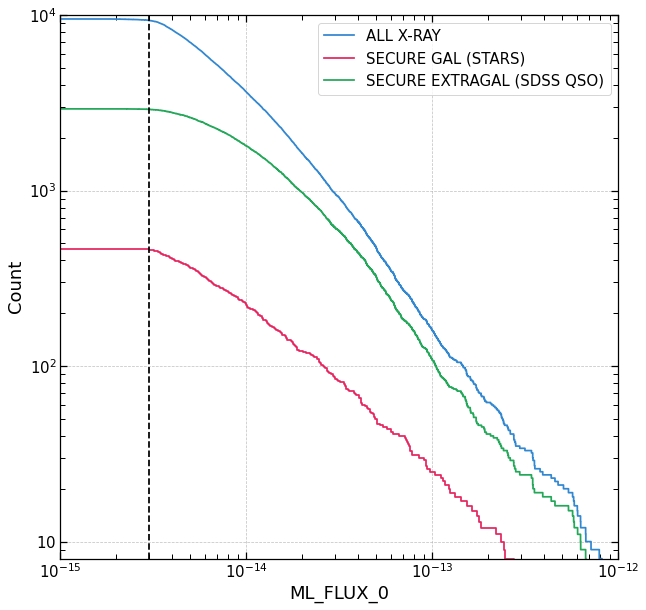

In [11]:
fig,  ax =  plt.subplots( figsize = (10,10))
sns.set_palette("Set2", color_codes=True)
sns.ecdfplot(desi.ML_FLUX_0, ax=ax, complementary=True, stat = 'count', label = 'ALL X-RAY')
sns.ecdfplot(desi.query("class_distance=='secure_gal'").ML_FLUX_0, ax=ax, complementary=True, stat = 'count', label = 'SECURE GAL (STARS)')
sns.ecdfplot(desi.query("class_distance=='secure_extragal'").ML_FLUX_0, ax=ax, complementary=True, stat = 'count', label = 'SECURE EXTRAGAL (SDSS QSO)')
ax.set(xscale="log", yscale="log")
ax.set(xlim=(1e-15, 1e-12), ylim = (8, 10000))
ax.axvline(3e-15, color='k', linestyle='--')
ax.legend()



/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='desi_fx_over_r', ylabel='Count'>

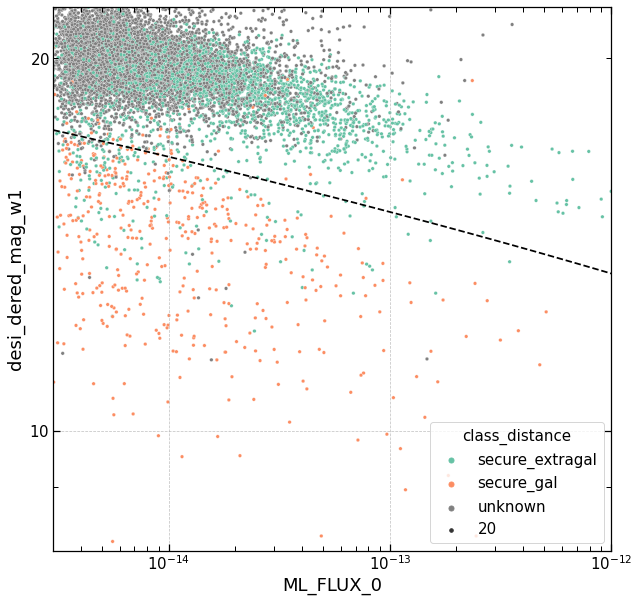

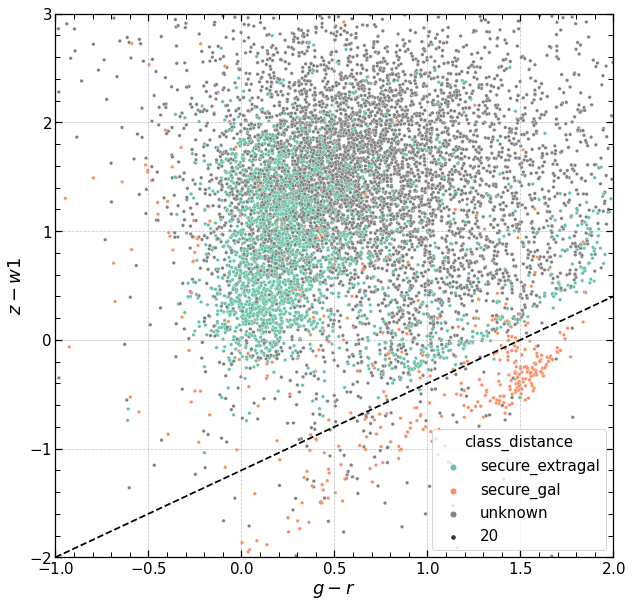

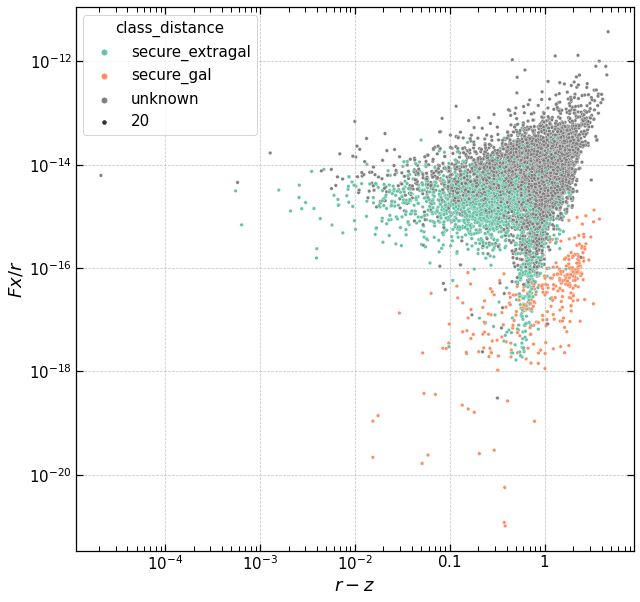

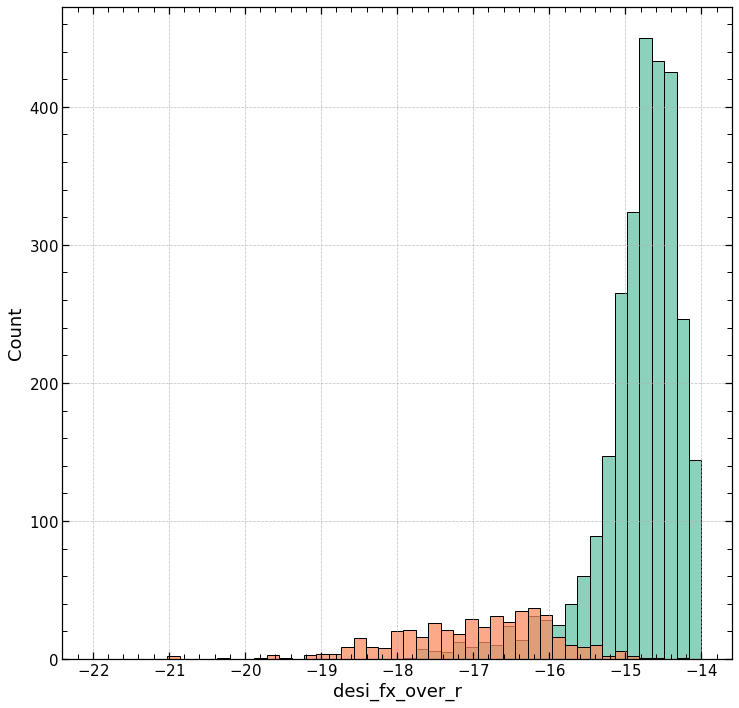

In [12]:
fig,  ax =  plt.subplots( figsize = (10,10))
sns.set_palette("Set2", color_codes=True)
sns.scatterplot(x='ML_FLUX_0', y='desi_dered_mag_w1', data=desi, ax = ax, **hue_args)
ax.set(xscale="log", yscale="log")
ax.set(xlim=(3e-15, 1e-12), ylim = (8, 22))

ax.plot(xrayflux:=np.logspace(-15,-10, 50), -6.101 - 1.625*np.log10(xrayflux), color='k', linestyle='--')

fig,  ax =  plt.subplots( figsize = (10,10))
sns.scatterplot(x='desi_col_gr', y='desi_col_zw1',  data=desi, ax = ax, **hue_args )
ax.set(xlim=(-1,2), ylim = (-2,3), xlabel='$g-r$', ylabel='$z-w1$')

ax.plot(gmr:=np.linspace(-1,2, 50), -1.2 + 0.8*gmr, color='k', linestyle='--')


fig,  ax =  plt.subplots( figsize = (10,10))
sns.scatterplot(x='desi_col_rz', y='desi_fx_over_r',  data=desi, ax = ax,**hue_args )
ax.set(ylabel='$Fx/r$', xlabel='$r-z$', xscale='log', yscale='log')

fig,  ax =  plt.subplots( figsize = (12,12))
bins = np.linspace(-22,-14,50)
sns.histplot(x = np.log10(desi.desi_fx_over_r[desi.class_distance=='secure_extragal']), bins = bins, ax = ax, color = 'C0')
sns.histplot(x = np.log10(desi.desi_fx_over_r[desi.class_distance=='secure_gal']), bins = bins, ax = ax, color = 'C1')
#ax.set(ylabel='$Fx/r$', xlabel='$r-z$', xscale='log', yscale='log')

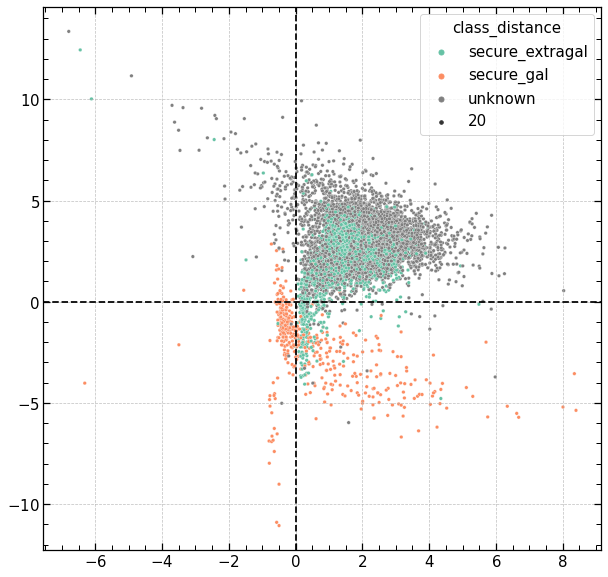

In [13]:
fig,  ax =  plt.subplots( figsize = (10,10))
col1 = desi['desi_dered_mag_z'] - desi['desi_dered_mag_w1'] + 1.2 -  0.8*(desi['desi_dered_mag_g']- desi['desi_dered_mag_r'])


col2 = desi['desi_dered_mag_w1'] + 1.625*np.log10(desi['ML_FLUX_0']) + 6.01


sns.scatterplot(x=col1, y=col2,  data=desi, ax = ax, **hue_args )
#ax.set(xlim=(-1,2), ylim = (-2,3), xlabel='$g-r$', ylabel='$z-w1$')

#ax.plot(gmr:=np.linspace(-1,2, 50), -1.2 + 0.8*gmr, color='k', linestyle='--')
ax.axhline(0, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')

# Train classification models

In [14]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay


def asses_classifier(desi, new_feature_name = 'class_fx_w1'):

    fig,  ax =  plt.subplots( figsize = (6,6))
    bins = np.linspace(desi[new_feature_name].min(), desi[new_feature_name].max(), 50)
    sns.histplot(desi.query("class_distance == 'secure_extragal'")[new_feature_name], bins=bins, ax=ax, label = 'secure_extragal')
    sns.histplot(desi.query("class_distance == 'secure_gal'")[new_feature_name], bins=bins, ax=ax, color = 'C1', label = 'secure_gal')
    ax.legend()

    true_negative = np.sum(desi.eval(f"{new_feature_name} < 0 & class_distance == 'secure_gal'"))
    false_positive = np.sum(desi.eval(f"{new_feature_name} > 0 & class_distance == 'secure_gal'"))
    false_negative = np.sum(desi.eval(f"{new_feature_name} < 0 & class_distance == 'secure_extragal'"))
    true_positive = np.sum(desi.eval(f"{new_feature_name} > 0 & class_distance == 'secure_extragal'"))
    print(new_feature_name)
    print(f"true_negative: {true_negative} - star classified as gal")
    print(f"false_positive: {false_positive} - star classified as extragal")
    print(f"false_negative: {false_negative} - QSO/Galaxy classified as gal")
    print(f"true_positive: {true_positive} - QSO/Galaxy classified as extragal")



def train_classifier(df, feature_x = 'ML_FLUX_0', feature_y = 'desi_dered_mag_w1',
    **clf_args):
    #ML_FLUX_0 x desi_dered_mag_w1
    #desi_col_gr x desi_col_zw1
    #desi_col_rz x desi_fx_over_r

    df_tmp = df.copy()
    df_traintest = df_tmp.query("class_distance in ['secure_gal', 'secure_extragal']")
    df_traintest['target'] = df_traintest['class_distance'].apply(lambda x: 0 if x == 'secure_gal' else 1)
    #replace inf with nan
    df_traintest = df_traintest.replace(np.inf, np.nan, inplace=False)
    df_traintest = df_traintest.replace(-np.inf, np.nan, inplace=False)
    df_traintest = df_traintest.dropna(subset=[feature_x, feature_y, 'target'], inplace=False)

    df_traintest = df_traintest[[feature_x, feature_y, 'target']]


    def my_scaler(df, feature):
        if feature == 'ML_FLUX_0':
            return np.log10(df[feature])+13
        elif feature == 'desi_dered_mag_w1':
            return df[feature] - 15
        else:
            return df[feature]
    

    df_traintest[feature_x] = df_traintest.apply(lambda x: my_scaler(x, feature_x), axis=1)
    df_traintest[feature_y] = df_traintest.apply(lambda x: my_scaler(x, feature_y), axis=1)

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_traintest[[feature_x, feature_y]], df_traintest['target'], test_size=0.01, random_state=42, stratify=df_traintest['target'])



    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values

    fig, axs =  plt.subplots(nrows=1, ncols = 3, sharex = True, sharey = True, gridspec_kw = {'hspace':0, 'height_ratios': None}, figsize = (15,8))
    ax, ax2, ax3 = axs
    ax.scatter(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], c='k', edgecolor="k", s = 20, zorder = 10)
    ax2.scatter(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], c='y', edgecolor="k", s = 20, zorder = 10)
    ax3.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor="k", zorder = 10, s = 10)


    clf = LogisticRegression(**clf_args)
    clf.fit(X_train, y_train)
    print('train roc-auc',sklearn.metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))


    DecisionBoundaryDisplay.from_estimator(
        clf, X_train, response_method="predict",
        alpha=0.5,
        ax = ax)
    DecisionBoundaryDisplay.from_estimator(
        clf, X_train, response_method="predict",
        alpha=0.5,
        ax = ax2)
    DecisionBoundaryDisplay.from_estimator(
        clf, X_train, response_method="predict",
        alpha=0.5,
        ax = ax3)

    coefs = clf.coef_[0]
    intercept = clf.intercept_[0]
    #coefs[0]*x + coefs[1]*y + intercept = 0 -> y = (-coefs[0]*x - intercept)/coefs[1]
    decision_boundary = lambda x: (-coefs[0]*x - intercept)/coefs[1]

    x = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)

    ax.plot(x, decision_boundary(x), color='k', linestyle='--')
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax2.plot(x, decision_boundary(x), color='k', linestyle='--')
    ax2.set_xlabel(feature_x)
    ax2.set_ylabel(feature_y)

    ax3.plot(x, decision_boundary(x), color='k', linestyle='--')
    ax3.set_xlabel(feature_x)
    ax3.set_ylabel(feature_y)

    print('FEATURES ARE SCALED')
    print(f"NEW FEATURE EQUATION: {coefs[0]:.3f}*{feature_x} + {coefs[1]:.3f}*{feature_y} + {intercept:.3f} > 0 -> extragal")
    print(f"NEW FEATURE EQUATION:  {feature_y} > ({-coefs[0]/coefs[1]:.3f}*{feature_x}) + ({-intercept/coefs[1]:.3f}) -> extragal")

    decision_func = lambda x, y = None: coefs[0]*x + coefs[1]*y + intercept
    plt.show()

    return clf, decision_func


train roc-auc 0.9703835852800924
FEATURES ARE SCALED
NEW FEATURE EQUATION: 2.634*ML_FLUX_0 + 1.438*desi_dered_mag_w1 + -0.359 > 0 -> extragal
NEW FEATURE EQUATION:  desi_dered_mag_w1 > (-1.832*ML_FLUX_0) + (0.250) -> extragal


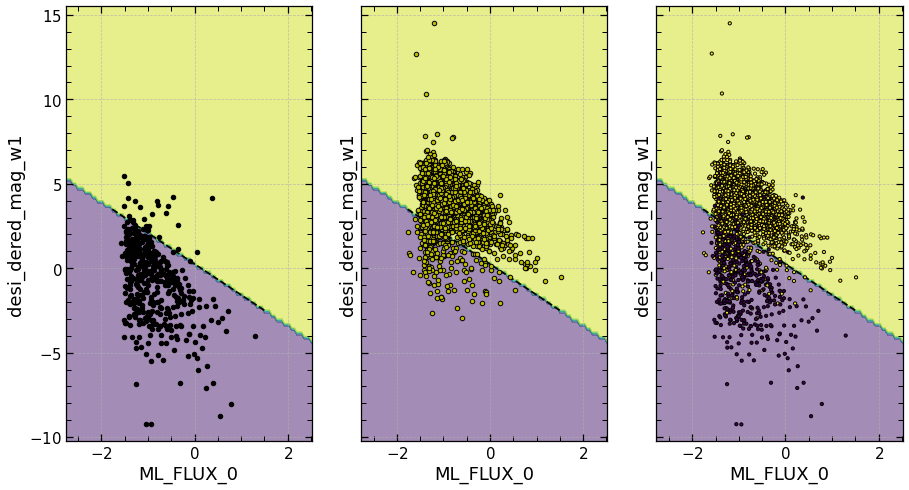

class_fxw1
true_negative: 439 - star classified as gal
false_positive: 27 - star classified as extragal
false_negative: 219 - QSO/Galaxy classified as gal
true_positive: 2699 - QSO/Galaxy classified as extragal


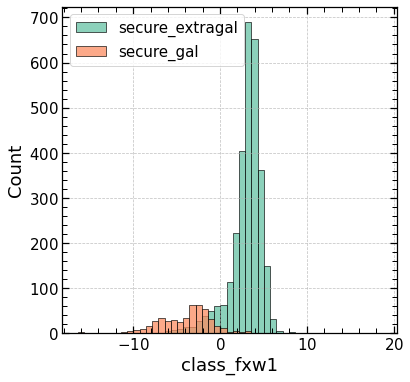

In [15]:

_, decision_func_fxw1 = train_classifier(desi, feature_x = 'ML_FLUX_0', feature_y = 'desi_dered_mag_w1', class_weight = 'balanced', C = 10)

desi['class_fxw1'] = decision_func_fxw1(np.log10(desi['ML_FLUX_0'])+13, desi['desi_dered_mag_w1'] - 15)

asses_classifier(desi, 'class_fxw1') 

train roc-auc 0.793453558434317
FEATURES ARE SCALED
NEW FEATURE EQUATION: -0.515*desi_col_gr + 1.471*desi_col_zw1 + 1.416 > 0 -> extragal
NEW FEATURE EQUATION:  desi_col_zw1 > (0.350*desi_col_gr) + (-0.963) -> extragal


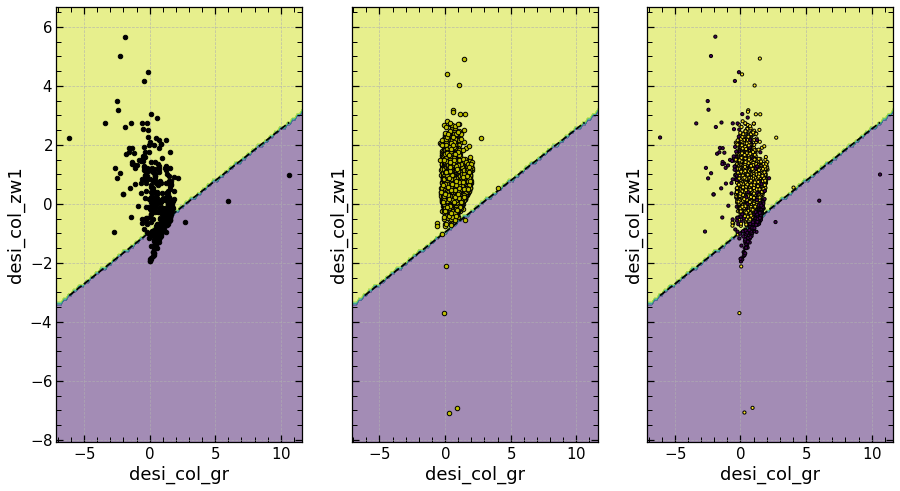

class_grzw1
true_negative: 110 - star classified as gal
false_positive: 337 - star classified as extragal
false_negative: 6 - QSO/Galaxy classified as gal
true_positive: 2912 - QSO/Galaxy classified as extragal


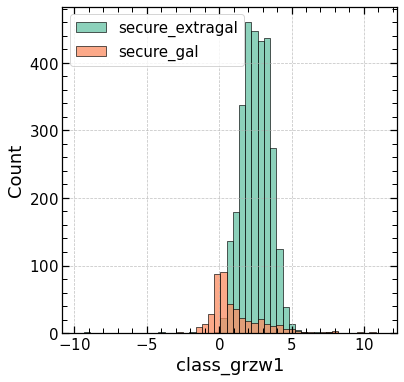

In [16]:

_, decision_func_grzw1 =  train_classifier(desi, feature_x = 'desi_col_gr', feature_y = 'desi_col_zw1',
class_weight = None, C = 1)

desi['class_grzw1'] = decision_func_grzw1(desi['desi_col_gr'], desi['desi_col_zw1'])

asses_classifier(desi, 'class_grzw1')

In [ ]:
# _, decision_func_fxw1 = train_classifier(desi, feature_x = 'ML_FLUX_0', feature_y = 'desi_col_w1w2', class_weight = 'balanced', C = 10)


# desi['class_fxw1w2'] = decision_func_fxw1(np.log10(desi['ML_FLUX_0'])+13, desi['desi_col_w1w2'])

# asses_classifier(desi, 'class_fxw1w2')

# Combine classification models

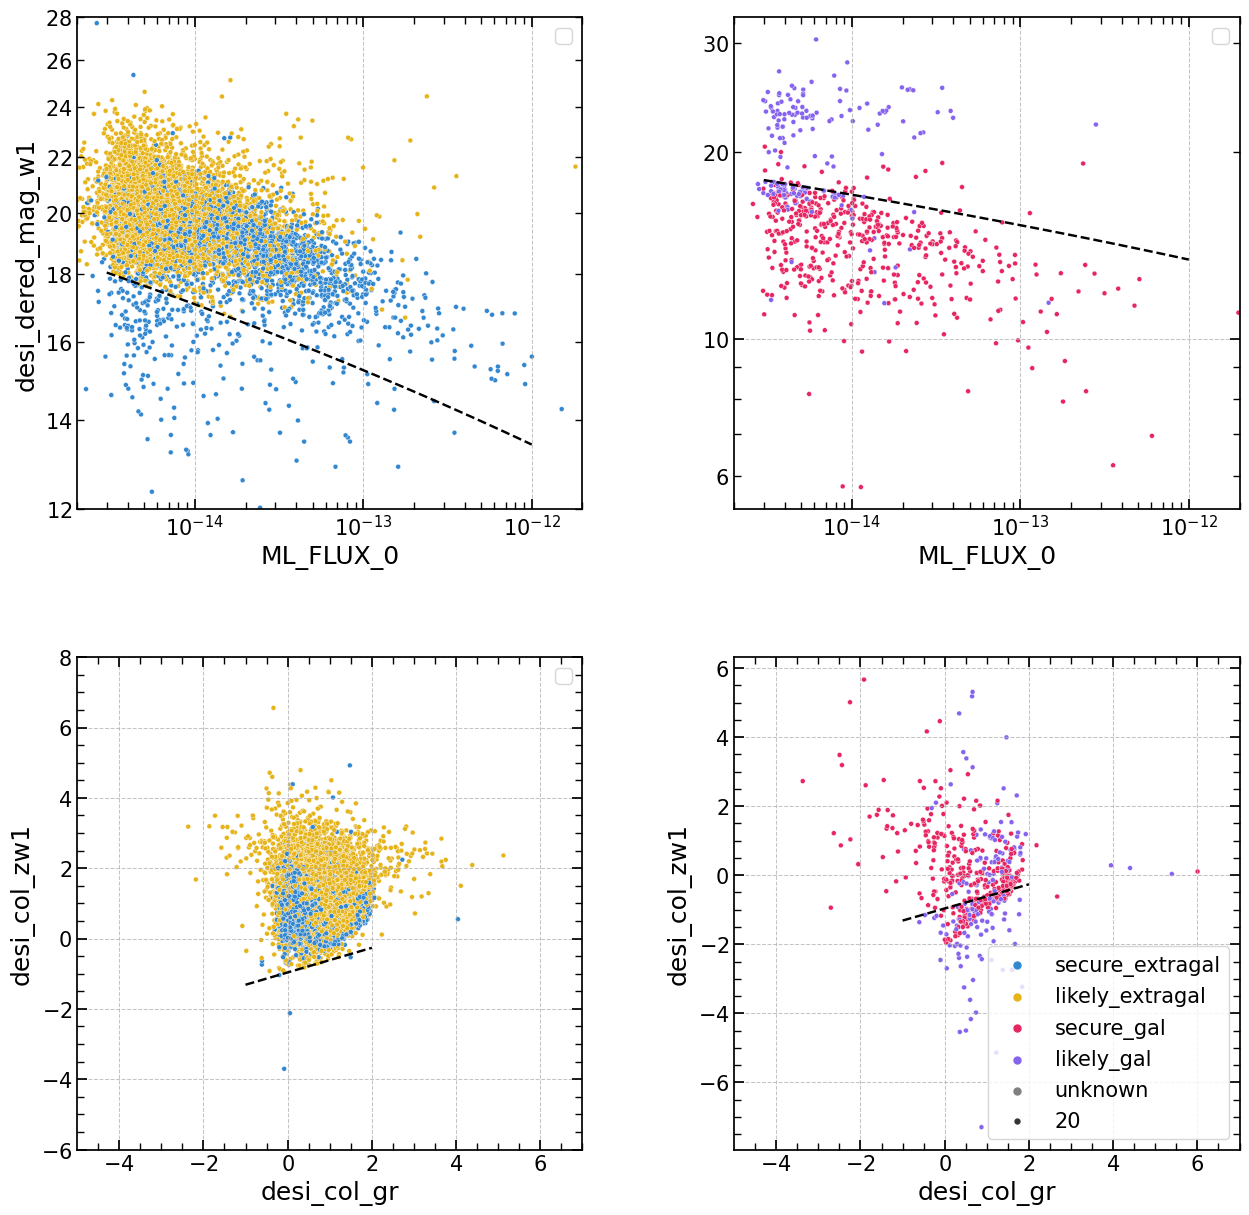

In [20]:
#reset likely classification if exsisting
desi.loc[desi.class_distance.isin(['likely_gal', 'likely_extragal']), 'class_distance'] = 'unknown'

# step 1: grzw1 classification:
condition = desi['class_grzw1']<0
desi.loc[(condition) & (desi.class_distance == 'unknown'), 'class_distance'] = 'likely_gal'



#step 2: FxW1 classification:
condition = desi['class_fxw1']>0

desi.loc[(condition) & (desi.class_distance == 'unknown'), 'class_distance'] = 'likely_extragal'
desi.loc[(~condition) & (desi.class_distance == 'unknown'), 'class_distance'] = 'likely_gal'



fig, axs =  plt.subplots(nrows=2, ncols = 2, sharex = 'row',   gridspec_kw = {'hspace':0.3, 'height_ratios': None, "wspace":0.3 }, figsize = (15,15))
ax1,ax2,ax3,ax4 = axs.flatten()

#sns relplot can do this?
sns.scatterplot(x='ML_FLUX_0', y='desi_dered_mag_w1',  data=desi.query("class_distance in ['likely_extragal','secure_extragal']"), ax = ax1, **hue_args_classified )
sns.scatterplot(x='desi_col_gr', y='desi_col_zw1',  data=desi.query("class_distance in ['likely_extragal','secure_extragal']"), ax = ax3, **hue_args_classified )



sns.scatterplot(x='ML_FLUX_0', y='desi_dered_mag_w1',  data=desi.query("class_distance in ['likely_gal','secure_gal']"), ax = ax2, **hue_args_classified )
sns.scatterplot(x='desi_col_gr', y='desi_col_zw1',  data=desi.query("class_distance in ['likely_gal','secure_gal']"), ax = ax4, **hue_args_classified )


#desi_col_zw1 > (0.350*desi_col_gr) + (-0.963) -> extragal
xaxis = np.linspace(-1, 2, 100)
decision_func_zw1 = 0.350*xaxis - 0.963
ax3.plot(xaxis, decision_func_zw1, color='k', linestyle='--')
ax4.plot(xaxis, decision_func_zw1, color='k', linestyle='--')


xaxis = np.geomspace(3e-15, 1e-12, 50)
#desi_dered_mag_w1 > (-1.832*ML_FLUX_0) + (0.250) -> extragal
decision_func_w1 = -1.832*(np.log10(xaxis)+13) + 0.250  + 15
ax1.plot(xaxis, decision_func_w1, color='k', linestyle='--')
ax2.plot(xaxis, decision_func_w1, color='k', linestyle='--')
ax1.set(xscale="log", yscale="log")
ax2.set(xscale="log", yscale="log")

ax1.set(ylim = (12, 28), xlim = (2e-15, 2e-12))


ax3.set(ylim = (-6, 8), xlim = (-5, 7))
ax2.set_ylabel('')
for ax in axs.flatten():
    ax.legend([])
    ax.grid(True)

ax4.legend()

<Figure size 1500x1500 with 0 Axes>

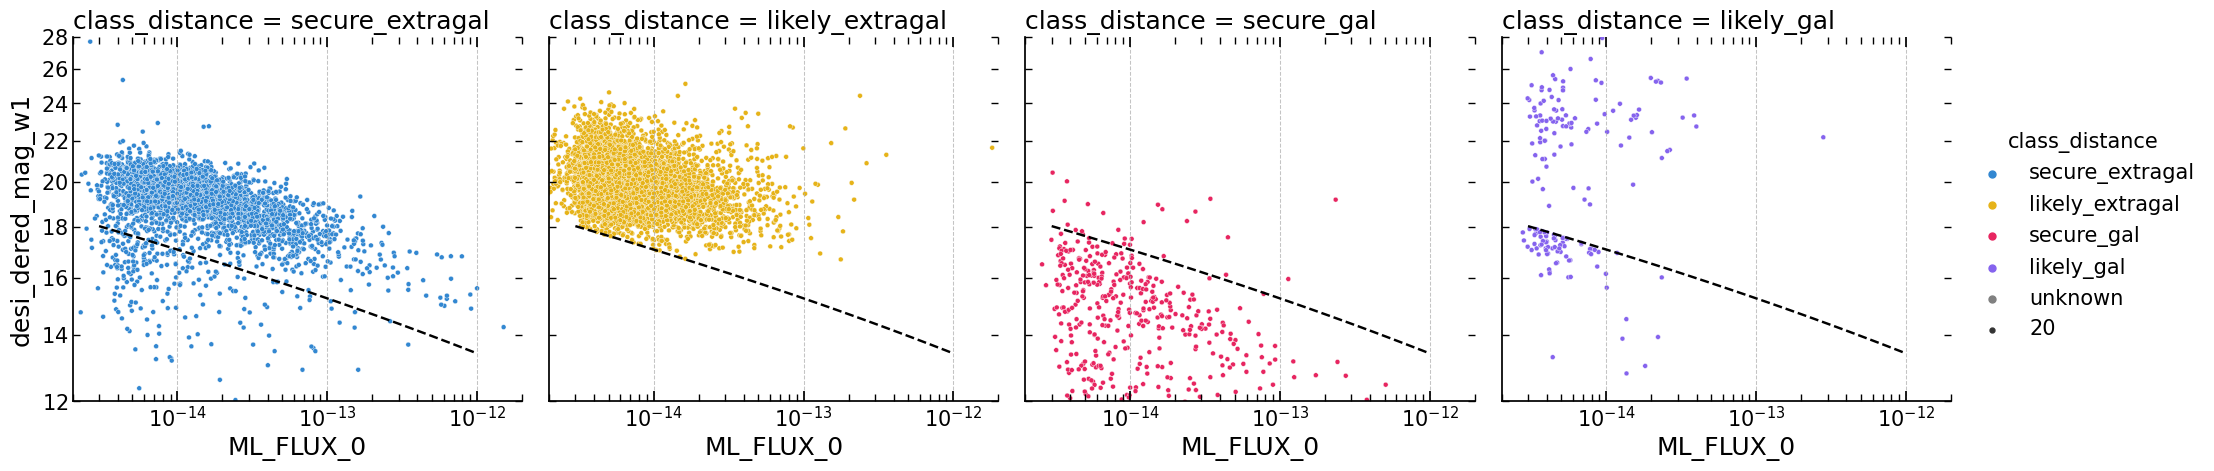

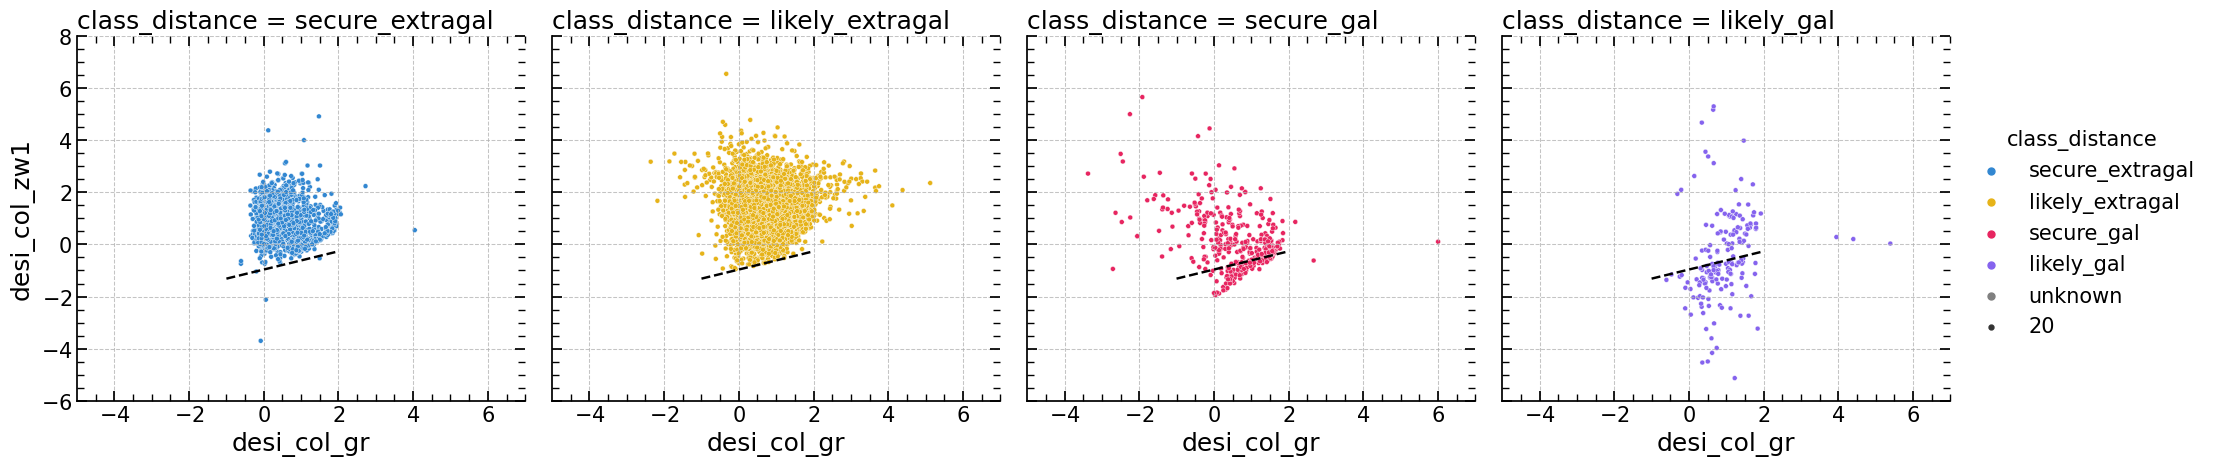

In [24]:
#sns.relplot(data=tips, x="total_bill", y="tip", hue="day", col="time")


#sns.scatterplot(x='ML_FLUX_0', y='desi_dered_mag_w1',  data=desi.query("class_distance in ['likely_gal','secure_gal']"), ax = ax2, **hue_args_classified )
set_mpl()
plt.figure(figsize=(15,15))
g = sns.relplot(x='ML_FLUX_0', y='desi_dered_mag_w1', data = desi, col = 'class_distance',  **hue_args_classified)

xaxis = np.geomspace(3e-15, 1e-12, 50)
for ax in g.fig.axes:
    ax.plot(xaxis, decision_func_w1, color='k', linestyle='--')

g.set(xscale="log", yscale="log")
g.set(ylim = (12, 28), xlim = (2e-15, 2e-12))



g = sns.relplot(x='desi_col_gr', y='desi_col_zw1', data = desi, col = 'class_distance',  **hue_args_classified)
xaxis = np.linspace(-1, 2, 100)
for ax in g.fig.axes:
    ax.plot(xaxis, decision_func_zw1, color='k', linestyle='--')

g.set(ylim = (-6, 8), xlim = (-5, 7))


In [26]:
desi.class_distance.value_counts()

likely_extragal    5750
secure_extragal    2921
secure_gal          466
likely_gal          363
Name: class_distance, dtype: int64

# EDA with new classes

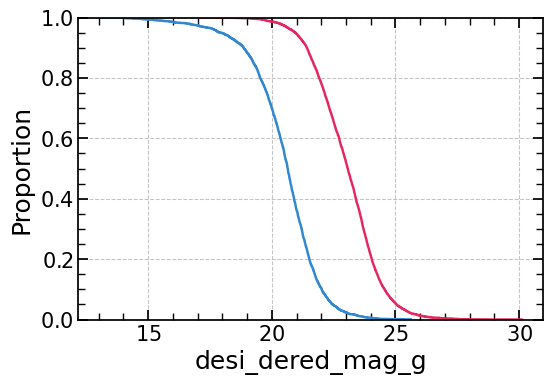

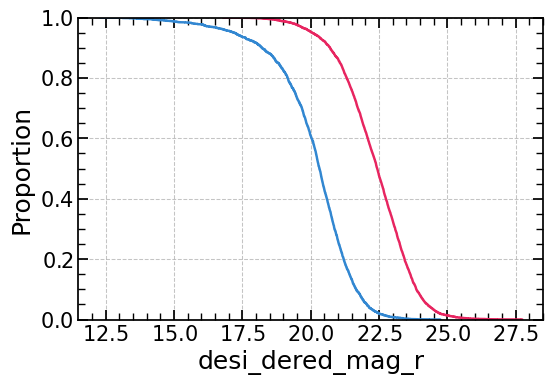

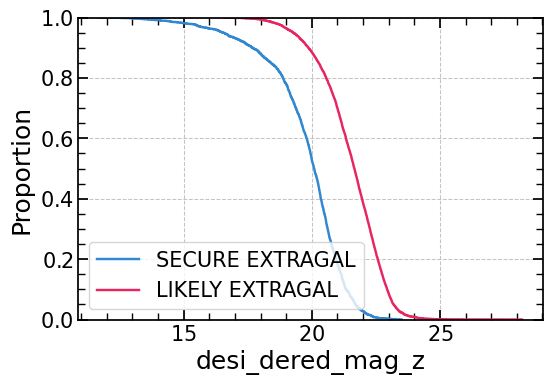

In [27]:
fig,  ax =  plt.subplots( figsize = (6,4))
sns.ecdfplot(desi.query("class_distance=='secure_extragal'").desi_dered_mag_g, ax=ax, complementary=True, stat = 'proportion', label = 'SECURE EXTRAGAL')
sns.ecdfplot(desi.query("class_distance=='likely_extragal'").desi_dered_mag_g, ax=ax, complementary=True, stat = 'proportion', label = 'LIKELY EXTRAGAL')

fig,  ax =  plt.subplots( figsize = (6,4))
sns.ecdfplot(desi.query("class_distance=='secure_extragal'").desi_dered_mag_r, ax=ax, complementary=True, stat = 'proportion', label = 'SECURE EXTRAGAL')
sns.ecdfplot(desi.query("class_distance=='likely_extragal'").desi_dered_mag_r, ax=ax, complementary=True, stat = 'proportion', label = 'LIKELY EXTRAGAL')

fig,  ax =  plt.subplots( figsize = (6,4))
sns.ecdfplot(desi.query("class_distance=='secure_extragal'").desi_dered_mag_z, ax=ax, complementary=True, stat = 'proportion', label = 'SECURE EXTRAGAL')
sns.ecdfplot(desi.query("class_distance=='likely_extragal'").desi_dered_mag_z, ax=ax, complementary=True, stat = 'proportion', label = 'LIKELY EXTRAGAL')


ax.legend()



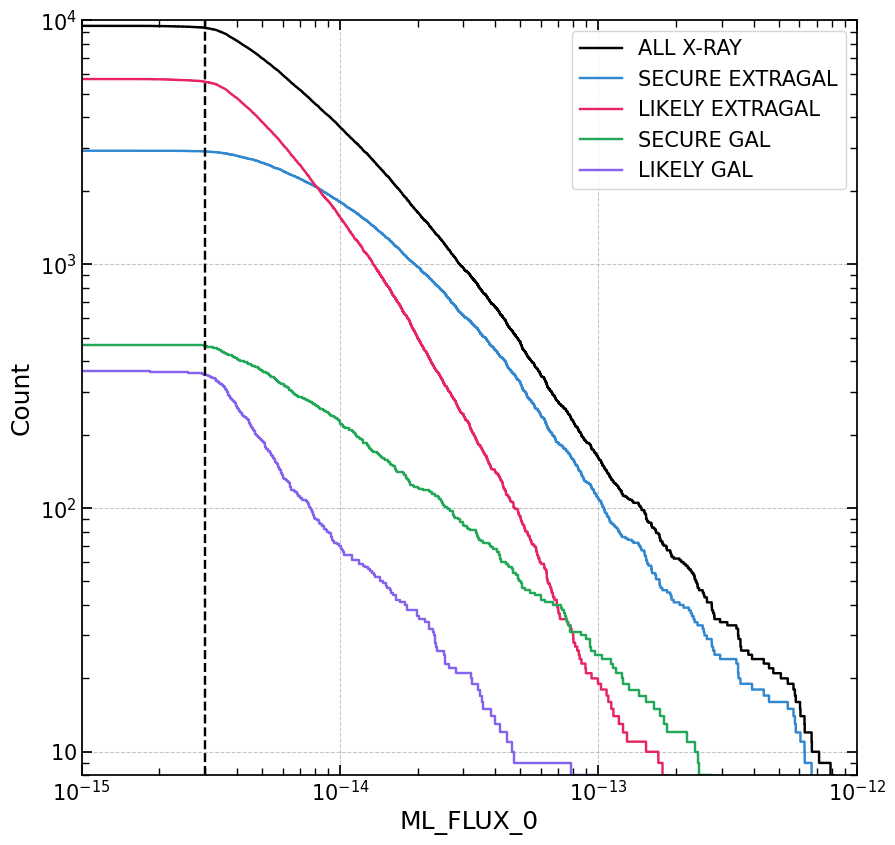

In [28]:
fig,  ax =  plt.subplots( figsize = (10,10))
sns.set_palette("Set2", color_codes=True)
sns.ecdfplot(desi.ML_FLUX_0, ax=ax, complementary=True, stat = 'count', label = 'ALL X-RAY', color = 'k')

sns.ecdfplot(desi.query("class_distance=='secure_extragal'").ML_FLUX_0, ax=ax, complementary=True, stat = 'count', label = 'SECURE EXTRAGAL')
sns.ecdfplot(desi.query("class_distance=='likely_extragal'").ML_FLUX_0, ax=ax, complementary=True, stat = 'count', label = 'LIKELY EXTRAGAL')

sns.ecdfplot(desi.query("class_distance=='secure_gal'").ML_FLUX_0, ax=ax, complementary=True, stat = 'count', label = 'SECURE GAL')
sns.ecdfplot(desi.query("class_distance=='likely_gal'").ML_FLUX_0, ax=ax, complementary=True, stat = 'count', label = 'LIKELY GAL')

ax.set(xscale="log", yscale="log")
ax.set(xlim=(1e-15, 1e-12), ylim = (8, 10000))
ax.axvline(3e-15, color='k', linestyle='--')
ax.legend()



In [29]:
import sys
sys.path.append('/Users/sdbykov/work/')
from forecast_clustering.scripts.luminosity_functions import XrayLuminosityFunction, ldde_hasinger_soft_cutoff

xlf_soft=XrayLuminosityFunction(xlf=ldde_hasinger_soft_cutoff)

Sarr = np.geomspace(3e-15, 1e-12, 20)
Sarr, logNlogS = xlf_soft.logNlogS(Sarr)

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


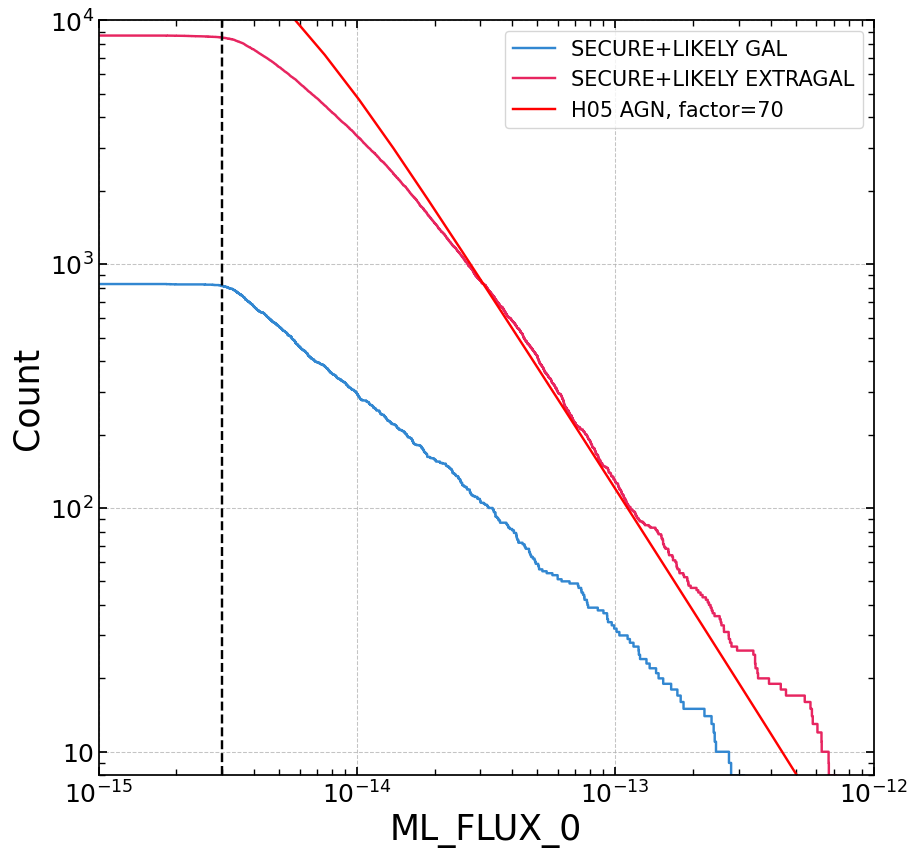

In [30]:
fig,  ax =  plt.subplots( figsize = (10,10))
sns.set_palette("Set2", color_codes=True)
#sns.ecdfplot(desi.ML_FLUX_0, ax=ax, complementary=True, stat = 'count', label = 'ALL X-RAY')
sns.ecdfplot(desi.query("class_distance in ['secure_gal', 'likely_gal'] ").ML_FLUX_0, ax=ax, complementary=True, stat = 'count', label = 'SECURE+LIKELY GAL')
sns.ecdfplot(desi.query("class_distance in ['secure_extragal', 'likely_extragal'] ").ML_FLUX_0, ax=ax, complementary=True, stat = 'count', label = 'SECURE+LIKELY EXTRAGAL')

ax.set(xscale="log", yscale="log")
ax.set(xlim=(1e-15, 1e-12), ylim = (8, 10000))
ax.axvline(3e-15, color='k', linestyle='--')
ax.legend()


factor = 70
plt.plot(Sarr, logNlogS*factor, color = 'r', label = f'H05 AGN, {factor=}')

plt.legend()

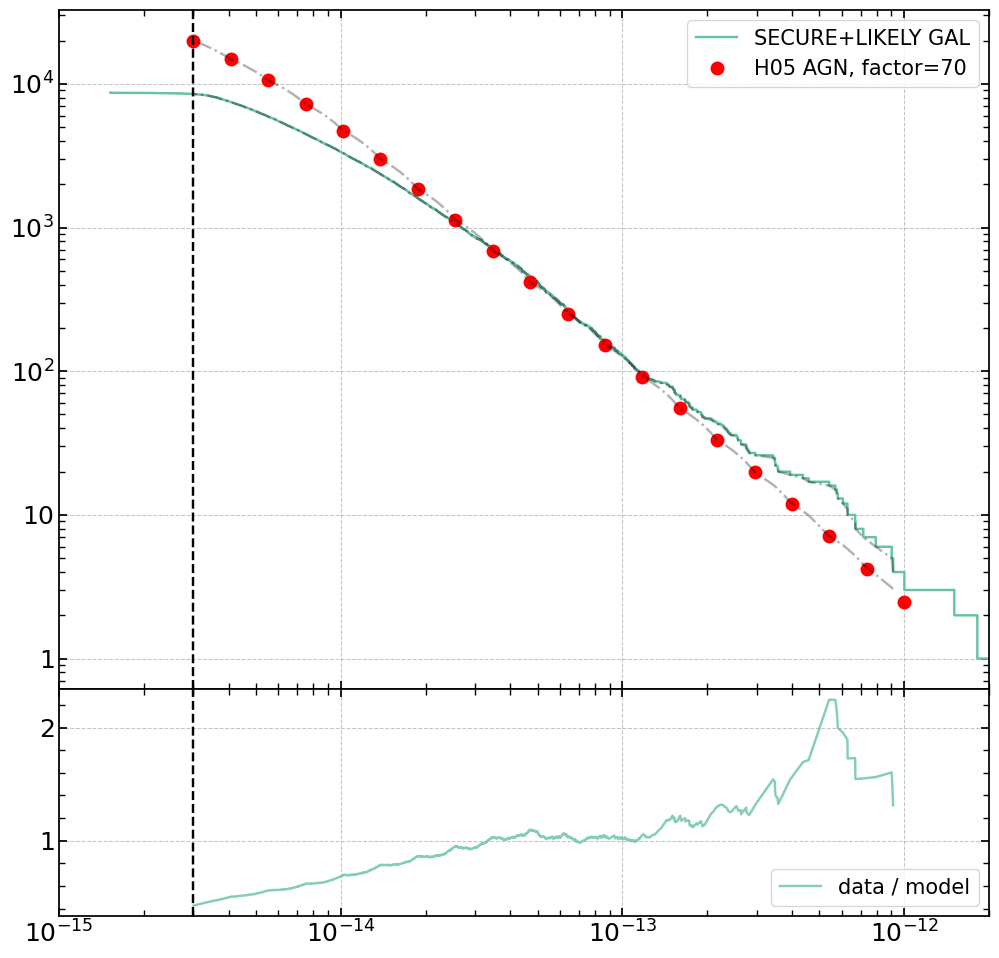

In [31]:
from scipy.interpolate import interp1d
def lnls_xy(f):
    """
    For an arbitrary input array f compute 2 arrays x,y
    for plotting cumulative logN-logS-like curve, making a step on each vallue of f
    array f does not have to be sorted
    returns tuple (x,y)
    for plotting use plt.plot(*lnls_xy(fx))
    """
    zz=np.sort(f)[::-1]
    n=np.arange(0,len(zz),1)

    x=np.array(np.transpose([zz,zz])).flatten()
    y=np.array(np.transpose([n,n+1])).flatten()

    return x,y

fx, lognlogs = lnls_xy(desi.query("class_distance in ['secure_extragal', 'likely_extragal'] ").ML_FLUX_0)


fig, axs =  plt.subplots(nrows=2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': [3,1]}, figsize = (12,12))
ax, ax2 = axs
ax.loglog(fx, lognlogs, label = 'SECURE+LIKELY GAL')
factor = 70
ax.plot(Sarr, logNlogS*factor,  'ro', label = f'H05 AGN, {factor=}')



lognlogs_interp = interp1d(fx, lognlogs, kind='linear')
lognlogs_xlf_interp  = interp1d(Sarr, logNlogS*factor, kind='linear')
fx = fx[(fx>Sarr.min()) & (fx<Sarr.max())]

ax.loglog(fx, lognlogs_interp(fx), 'k-.', alpha = 0.3)
ax.loglog(fx, lognlogs_xlf_interp(fx), 'k-.',  alpha = 0.3)

ax2.plot(fx, lognlogs_interp(fx)/lognlogs_xlf_interp(fx), alpha = 0.8, label = 'data / model')

for ax in [ax,ax2]:
    ax.set(xlim=(1e-15, 2e-12))
    ax.axvline(3e-15, color='k', linestyle='--')
    ax.legend()


